In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import read_functions as read
import ak_functions as ak
import utils
import plot_functions as pf
import pandas as pd
import scipy.linalg as linalg
%load_ext fortranmagic

# 1. Read in data
You will probably need to replace this cell with your own read function. 

You will want to have 3 variables at the end of this read function:
- `gc_pedge` 
    - GEOS-Chem pressure edges colocated at each obsevation
    - dimensions: `n_observations x n_gc_levels` 
- `obs_pedge`
    - Satellite observation pressure edges. One for each observation.
    - dimensions: `n_observations x n_observation_levels` 
- `gc_ch4_native`
    - GEOS-Chem methane layers colocated at each observation 
    - dimensions: `n_observations x n_gc_levels-1`
    
If they are all type `np.array` this should work fine. But other types probably work too. 

In [2]:
# read in data
diag_dir = '~/satobs_test/20130114/'
#sat = 'gosat'
sat = 'airs'

if sat == 'gosat':
    prefix = 'out_'
if sat == 'airs':
    prefix = 'out_airs_'

varnames = [ 'GC_PEDGE', 'GC_CH4_NATIVE', 'DRY_AIR', 
             'GOS_PEDGE', 'GC_CH4', 'GC_CH4_ORIG', 'DRY_INTERP', 
             'GOSAT_PRES_W', 'BRAMS_PW', 'ZHENS_PW' ]

filenames = ['out_{}.m'.format(varname) for varname in varnames]

def convert_to_xr(pd_df):
    IDs = pd_df.index
    lev = np.arange(len(pd_df.columns))+1
    xr_da = xr.DataArray(coords=[IDs,lev], dims=['observations','lev{}'.format(len(lev))])
    for obs,row in pd_df.iterrows():
        xr_da.loc[obs,:] = np.array(row)
    return xr_da

# read in your 2D output files
first = True
for varname in varnames:
    filepath = '{}{}{}.m'.format(diag_dir,prefix,varname)
    pd_df = pd.read_csv(filepath, delim_whitespace=True)
    if sat == 'gosat':
        pd_df = pd_df.set_index('ID')
    if first:
        IDs = pd_df.index
        lev = np.arange(len(pd_df.columns))+1
        profiles = xr.Dataset()
        first = False
    profiles[varname] = convert_to_xr(pd_df)
    
# slap attributes from sat_obs on the same array
if sat == 'gosat':
    filepath = '{}final_gosat.m'.format(diag_dir)
    #'~/work/satobs/20130114/sat_obs.gosat.default_withzhen_1.m'
    obs_attrs = pd.read_csv(filepath, delim_whitespace=True).rename(columns={'EXPOSURE_ID':'ID'}).set_index('ID')
    for varname in obs_attrs.columns:
        profiles[varname] = xr.DataArray(obs_attrs[varname],dims={'observations':IDs})
if sat == 'airs':
    filepath = '{}sat_obs.airs.00.m'.format(diag_dir)
    obs_attrs = pd.read_csv(filepath, delim_whitespace=True)
    for varname in obs_attrs.columns:
        profiles[varname] = xr.DataArray(obs_attrs[varname],dims='observations') 
    
# define some useful variables
nsatlev = profiles['GOS_PEDGE'].shape[1]
nobs = profiles['GOS_PEDGE'].shape[0]
gc_pedge = profiles['GC_PEDGE'].data
gos_pw = profiles['GOSAT_PRES_W'].data
obs_pedge = profiles['GOS_PEDGE'].data
gc_ch4_native = profiles['GC_CH4_NATIVE'].data

# 2. Get lowest valid level

Both GOSAT and AIRS sometimes have missing values in layers adjacent to the surface. There is sometimes more than 1 missing level, but they are always adjacent to the surface (for example: If the second level is missing, so is the first. But you can't have the first layer defined and the second layer defined). 

As a result, you can just find the "lowest valid level" for each set of vertical levels. We calculate this separately and pass this to the interpolation because the criteria for a "valid level" is different for different products. 

`L0` is an array of shape nobs which contains the lowest valid level for each observation. 

If you know you never have any missing value, you can just set every element in `L0` to 0. Otherwise, you need to use this function (if the criteria for a valid level is the same) or write your own. 

Note that the interpolation function can handle missing levels only if they are adjacent to the surface. It can't handle missing levels at the TOA or "gaps," for example if there's a missing level between two defined levels. 

In [3]:
# FOR AIRS ETC -  ALREADY HAVE THIS FUNCTION FOR EACH SATELLITE
    # People will have to rewrite it for their own satellite
    # So don't rewrite it

# get first nonmissing value
# for AIRS you also need to ignore levels where pressure weight is 0!
def get_lowest_valid_lev(gos_pedge,gos_pw=None,skip_h=False):
    nobs = gos_pedge.shape[0]
    L0 = np.full(nobs,int(-1))
    for i in np.arange(nobs):
        if skip_h:
            for lev,(p,h) in enumerate(zip(gos_pedge[i].data,
                                           gos_pw[i].data)):
                # temp erp don't include levels where PRES_W is 0!
                if p>0 and h>0:
                    L0[i] = int(lev)
                    break
        else: 
            # get first nonmissing value
            # for AIRS you also need to ignore levels where pressure weight is 0!
            for lev,p in enumerate(gos_pedge[i].data):
                # temp erp don't include levels where PRES_W is 0!
                if p>0:
                    L0[i] = int(lev)
                    break
    return L0

# L0 is an array of shape nobs which contains the lowest valid level for each observation
L0 = get_lowest_valid_lev(obs_pedge,gos_pw,skip_h=True)

# 3. Interpolate

The giant block below is the interpolation functin written in FORTRAN. It is based on "Total mass-conserved regridding of concentration-type quantities defined on vertical levels" as described in Keppens 2019: https://doi.org/10.5194/amt-12-4379-2019. 

`%%fortran` wraps this FORTRAN code into Python functions so we can call it from Python. But it runs fast because it's in FORTRAN. And I will mostly drag-and-drop this code into gosat_ch4_mod.F. 

This code is called in one line in the next block, and saved into the variable `ch4_edges`. This is the GEOS-Chem concentrations interpolated onto GOSAT edges.  

If you get bugs you can use `--f90flags "-fcheck=all"` to print errors to the console. 

In [4]:
%%fortran 

! calculate HPRIME pressure edges from equation 11 of Keppens 2019
SUBROUTINE H_TO_HPRIME_F( OBS_PEDGE, L0, nlev_obs, HPRIME )

    ! definition of GEOS-Chem precision for python
    integer, parameter :: fp = selected_real_kind(15, 307)

    ! !INPUT PARAMETERS:
    INTEGER,  INTENT(IN)  :: nlev_obs, L0
    REAL(fp), INTENT(IN)  :: OBS_PEDGE(nlev_obs)
        
    ! !OUTPUT PARAMETERS:
    REAL(fp), INTENT(OUT) :: HPRIME(nlev_obs+1)
    
    
    ! !LOCAL VARIABLES:
    INTEGER :: L

    ! Initialize
    HPRIME(:) = -9999.0_fp  ! this is your missing value
    
    HPRIME(L0) = OBS_PEDGE(L0)
    HPRIME(nlev_obs+1) = OBS_PEDGE(nlev_obs)
    ! Loop over each pressure level of observation grid
    DO L = L0+1, nlev_obs
        HPRIME(L) = 0.5_fp*OBS_PEDGE(L) + 0.5_fp*OBS_PEDGE(L-1)
    ENDDO
    
END SUBROUTINE H_TO_HPRIME_F

! extend GEOS-Chem pressure levels so they cover the full vertical range 
!   of the observations
SUBROUTINE EXTEND_GC_F( GC_PEDGE, OBS_PEDGE, L0, nlev_gc, nlev_obs, GC_PEDGE_EXT )

    ! definition of GEOS-Chem precision for python
    integer, parameter :: fp = selected_real_kind(15, 307)

    ! !INPUT PARAMETERS:
    INTEGER,  INTENT(IN) :: nlev_obs, nlev_gc, L0
    REAL(fp), INTENT(IN) :: GC_PEDGE(nlev_gc+1)
    REAL(fp), INTENT(IN) :: OBS_PEDGE(nlev_obs)
        
    ! !OUTPUT PARAMETERS:
    REAL(fp), INTENT(OUT) :: GC_PEDGE_EXT(nlev_gc+1)
    
    
    ! !LOCAL VARIABLES:
    ! none! :)

    ! Initialize
    GC_PEDGE_EXT(:) = 0.0_fp
    GC_PEDGE_EXT(:) = GC_PEDGE(:)
    
    ! if observation surf pres. is higher than model, then
    ! extend the surface model layer down to the obs. surface
    IF ( OBS_PEDGE(L0) > GC_PEDGE(1) ) THEN
        GC_PEDGE_EXT(1) = OBS_PEDGE(L0)
    ENDIF
    
    ! if observation TOA pres. is lower than model, then 
    ! extend the top model layer up to the obs. TOA
    IF ( OBS_PEDGE(nlev_obs) < GC_PEDGE(nlev_gc+1) ) THEN
        GC_PEDGE_EXT(nlev_gc+1) = OBS_PEDGE(nlev_obs)
    ENDIF
    
END SUBROUTINE EXTEND_GC_F

! OVERLAP_MAP is W in eq 13 of Keppens 2013
SUBROUTINE GET_OVERLAP_MAP(  GC_PEDGE, OBS_PEDGE,&
                        L0, nlev_gc, nlev_obs, OVERLAP_MAP)

    ! definition of GEOS-Chem precision for python
    integer, parameter :: fp = selected_real_kind(15, 307)
    
    !
    ! !INPUT PARAMETERS:
    !
    INTEGER,  INTENT(IN)  :: nlev_gc
    INTEGER,  INTENT(IN)  :: nlev_obs
    REAL(fp), INTENT(IN)  :: GC_PEDGE(nlev_gc)
    REAL(fp), INTENT(IN)  :: OBS_PEDGE(nlev_obs)
    INTEGER,  INTENT(IN)  :: L0 ! lowest valid observation level 
    !
    ! !OUTPUT PARAMETERS:
    !
    REAL(fp), INTENT(OUT) :: OVERLAP_MAP(nlev_obs-1,nlev_gc-1)
    !
    ! !REVISION HISTORY:
    !  23 Sep 2020 - Elise Penn - get map of layer overlaps based on interpolation in 
    !                Langerock et a. 2015 and used in equation 13 of Keppens et al. 2019. 
    !                See description of "mass-conserved regridding" in Keppens et al. 2019: 
    !                https://doi.org/10.5194/amt-12-4379-2019
    !EOP
    !------------------------------------------------------------------------------
    !BOC
    !
    ! !LOCAL VARIABLES:
    !
    INTEGER  :: LGC, LTM
    REAL(fp) :: DIFF
    REAL(fp) :: LOW_GC, HI_GC
    REAL(fp) :: LOW_OBS, HI_OBS
    !=================================================================
    ! GET_OVERLAP_MAP begins here!
    !=================================================================

    ! Initialize
    OVERLAP_MAP(:,:) = 0e+0_fp
    
    ! Loop over each pressure level of observation retrieval grid
    DO LTM = L0, nlev_obs-1

        LOW_OBS = OBS_PEDGE(LTM+1)
        HI_OBS  = OBS_PEDGE(LTM)
            
        ! Find the levels from GC that bracket level LTM
        DO LGC = 1, nlev_gc-1

            LOW_GC = GC_PEDGE(LGC+1)
            HI_GC  = GC_PEDGE(LGC)

            ! Match GEOS-Chem level to observation level
            IF ( ( HI_OBS  <= HI_GC .and.&
                   HI_OBS  >  LOW_GC ) .or.&
                 ( LOW_OBS <= HI_GC .and.&
                   LOW_OBS >  LOW_GC ) .or.&
                 ( HI_GC   <= HI_OBS .and.&
                   HI_GC   >  LOW_OBS ) .or.&
                 ( LOW_GC  <= HI_OBS .and.&
                   LOW_GC  >  LOW_OBS ) )&
            THEN

                DIFF             = HI_GC- LOW_GC
                OVERLAP_MAP(LTM,LGC) = ( MIN(HI_OBS,HI_GC) -&
                                    MAX(LOW_OBS,LOW_GC) ) /&
                                    DIFF
                
            ENDIF

        ENDDO

    ENDDO
    
END SUBROUTINE GET_OVERLAP_MAP

! Perform interpolation from model levels to the levels of your observation. 
! Based on equation 13 of Keppens 2019
SUBROUTINE MASS_INTERP( GC_PEDGE, OBS_PEDGE, GC_CH4_NATIVE, L0, nlev_gc, nlev_obs, CH4_INTERP_EDGES )

    ! definition of GEOS-Chem precision for python
    integer, parameter :: fp = selected_real_kind(15, 307)

    ! !INPUT PARAMETERS:
    INTEGER,  INTENT(IN) :: nlev_obs, nlev_gc, L0
    REAL(fp), INTENT(IN) :: GC_PEDGE(nlev_gc+1)
    REAL(fp), INTENT(IN) :: GC_CH4_NATIVE(nlev_gc)
    REAL(fp), INTENT(IN) :: OBS_PEDGE(nlev_obs)
        
    ! !OUTPUT PARAMETERS:
    REAL(fp), INTENT(OUT) :: CH4_INTERP_EDGES(nlev_obs)
    
    
    ! !LOCAL VARIABLES:
    REAL(fp) :: GC_PEDGE_EXT(nlev_gc+1), OBS_HPRIME(nlev_obs+1)
    REAL(fp) :: OVERLAP_MAP(nlev_obs,nlev_gc)
    REAL(fp) :: M_obs(nlev_obs), M_gc(nlev_gc)
    REAL(fp) :: CH4_INTERP_INTEGRATED(nlev_obs)
    REAL(fp) :: CH4_MODEL_INTEGRATED(nlev_gc)
    INTEGER  :: LGC, LOBS
    
    ! Initialize
    CH4_INTERP_EDGES(:) = 0.0_fp ! note your missing value is 0
    
    ! extend GEOS-Chem so it covers the full vertical range 
    !   of the observations
    CALL EXTEND_GC_F( GC_PEDGE, OBS_PEDGE, L0, nlev_gc+1, nlev_obs, GC_PEDGE_EXT )
    ! calculate HPRIME pressure edges from equation 11
    CALL H_TO_HPRIME_F( OBS_PEDGE, L0, nlev_obs, OBS_HPRIME )
    ! OVERLAP_MAP is W in eq 13
    CALL GET_OVERLAP_MAP( GC_PEDGE_EXT, OBS_HPRIME, L0, nlev_gc+1, nlev_obs+1, OVERLAP_MAP )
    
    ! M_gc and M_obs are M_in and M_out from eq 14
    ! They are diagonal matrices, so we can use a vector
    M_gc(:) = 0.0_fp
    DO LGC = 1, nlev_gc
       M_gc(LGC) = GC_PEDGE_EXT(LGC) - GC_PEDGE_EXT(LGC+1)
    ENDDO
    M_obs(:) = 0.0_fp
    DO LOBS = L0, nlev_obs
       M_obs(LOBS) = OBS_HPRIME(LOBS) - OBS_HPRIME(LOBS+1)
    ENDDO
    
    ! Intermediate steps for eq 14:
    ! 1) M_in * x
    CH4_MODEL_INTEGRATED(:) = 0.0_fp
    DO LGC = 1, nlev_gc
        CH4_MODEL_INTEGRATED(LGC) = M_gc(LGC) * GC_CH4_NATIVE(LGC)
    ENDDO
    ! 2) W * M_in * x (matrix multiply W and M_in*x)
    CH4_INTERP_INTEGRATED(:) = 0.0_fp
    DO LGC = 1, nlev_gc
        DO LOBS = L0, nlev_obs
            CH4_INTERP_INTEGRATED(LOBS) = CH4_INTERP_INTEGRATED(LOBS) +&
                        OVERLAP_MAP(LOBS,LGC) * CH4_MODEL_INTEGRATED(LGC)
        ENDDO
    ENDDO
    ! 3) inv(M_out) * W * M_in * x
    DO LOBS = L0, nlev_obs
        ! inv(M_out) = 1/M_out because it is diagonal
        CH4_INTERP_EDGES(LOBS) = 1.0_fp/M_obs(LOBS) *&
                                 CH4_INTERP_INTEGRATED(LOBS)
    ENDDO
    
END SUBROUTINE MASS_INTERP

# ! This subroutine is just for use in Python
# ! It loops over each observation just to make the loop faster. Happy birthday. 
# SUBROUTINE MASS_INTERP_LOOP( GC_PEDGE, OBS_PEDGE, GC_CH4_NATIVE, L0,&
#                              nobs, nlev_gc, nlev_obs, CH4_INTERP_EDGES )

#     ! definition of GEOS-Chem precision for python
#     integer, parameter :: fp = selected_real_kind(15, 307)

#     ! !INPUT PARAMETERS:
#     INTEGER,  INTENT(IN) :: nobs, nlev_obs, nlev_gc
#     INTEGER,  INTENT(IN) :: L0(nobs)
#     REAL(fp), INTENT(IN) :: GC_PEDGE(nlev_gc+1,nobs)
#     REAL(fp), INTENT(IN) :: GC_CH4_NATIVE(nlev_gc,nobs)
#     REAL(fp), INTENT(IN) :: OBS_PEDGE(nlev_obs,nobs)
        
#     ! !OUTPUT PARAMETERS:
#     REAL(fp), INTENT(OUT) :: CH4_INTERP_EDGES(nlev_obs,nobs)
            
#     ! !LOCAL PARAMETERS:
#     REAL(fp) :: CH4_INTERP_EDGES_N(nlev_obs)
#     INTEGER  :: N
    
#     ! Initialize
#     CH4_INTERP_EDGES(:,:) = 0.0_fp
#     CH4_INTERP_EDGES_N(:) = 0.0_fp
#     DO N = 1,nobs
#         CALL MASS_INTERP( GC_PEDGE(:,N), OBS_PEDGE(:,N), GC_CH4_NATIVE(:,N), L0(N),&
#                           nlev_gc, nlev_obs, CH4_INTERP_EDGES_N )
#         CH4_INTERP_EDGES(:,N) = CH4_INTERP_EDGES_N(:)
#     ENDDO
            
# END SUBROUTINE MASS_INTERP_LOOP

In [5]:
ch4_edges = np.full((nobs,nsatlev),np.nan)
for i in np.arange(nobs):
    ch4_edges[i] = mass_interp(gc_pedge[i], obs_pedge[i], 
                                   gc_ch4_native[i], L0[i]+1)

# 4. Check that your profiles look correct

Just check it by eye here. Make sure you include some edge cases, such as:
- if GEOS-Chem starts before GOSAT
- if GOSAT starts before GEOS-Chem
- if a GEOS-Chem layer is fully within a GOSAT layer
- if a GOSAT layer is fully within a GEOS-Chem layer

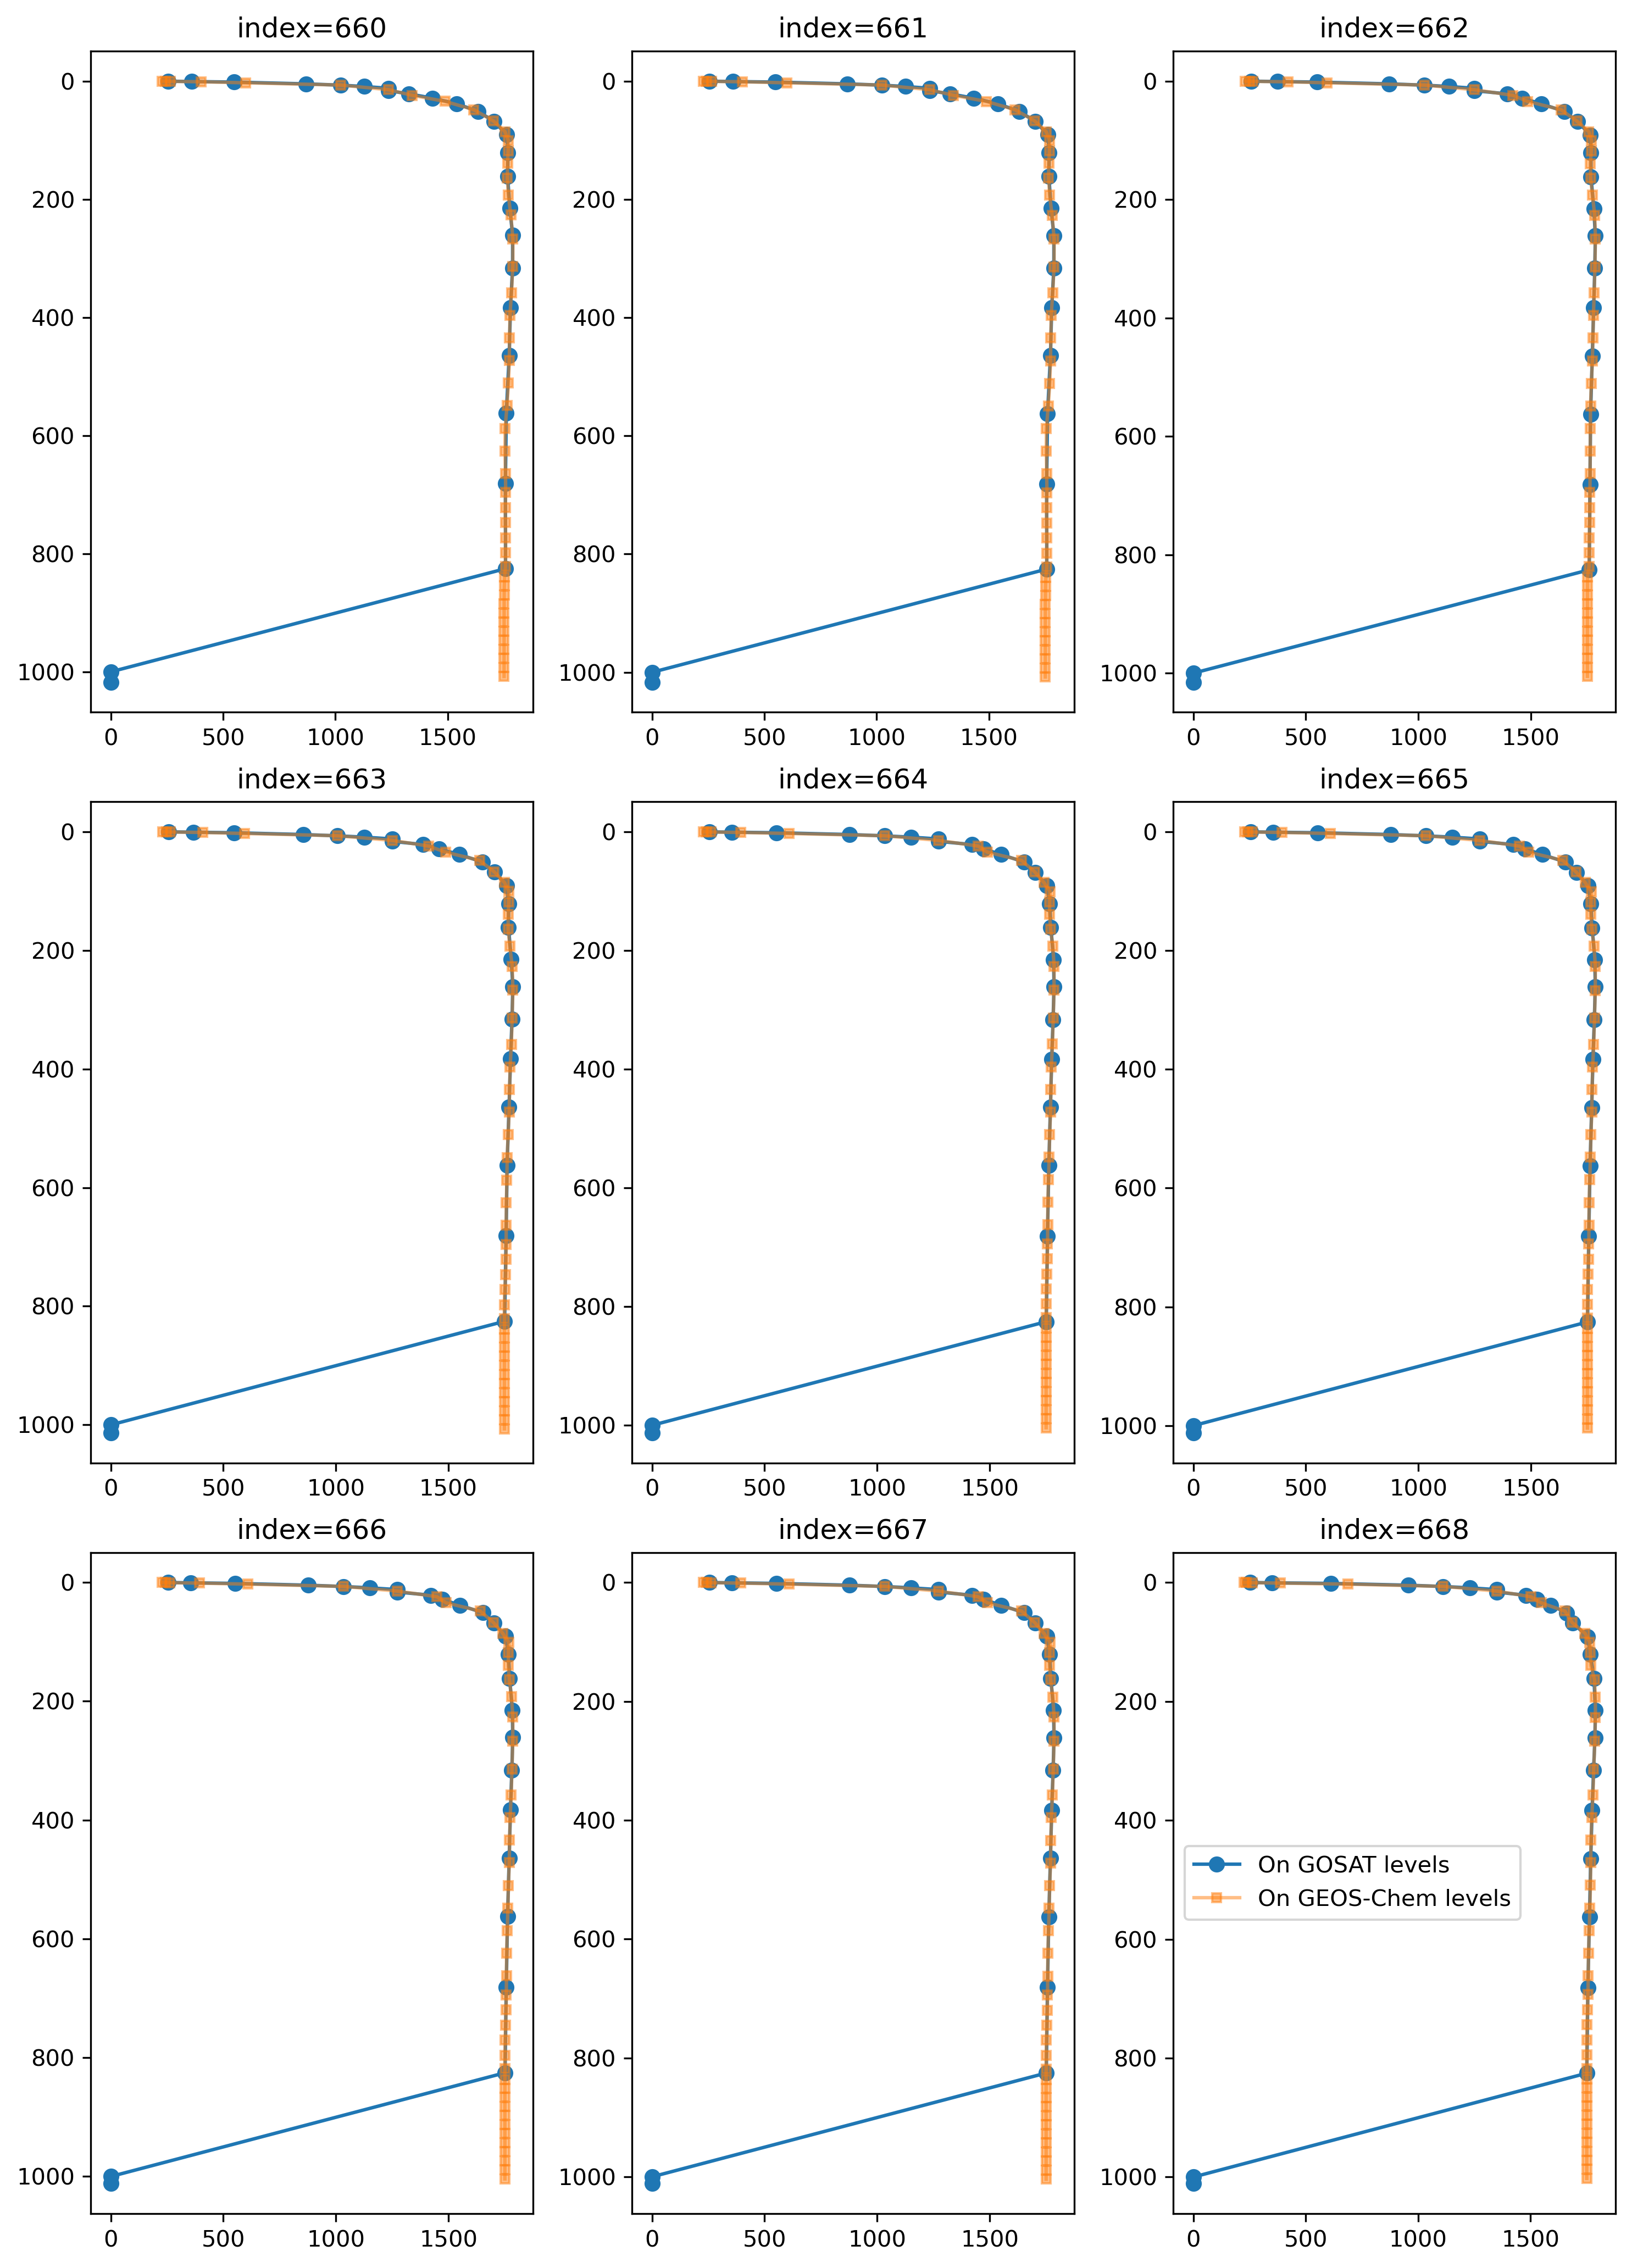

In [6]:
startint = 660
nrow = 3
ncol = 3
plt.subplots(nrow,ncol, figsize=(10,15),dpi=300)

gc_pcent =  (gc_pedge[:,1:] + gc_pedge[:,:-1].data)/2.
for i,index in enumerate(np.arange(9)+startint): 
    plt.subplot(nrow,ncol,i+1) 
    plt.plot(ch4_edges[index]*1e9,obs_pedge[index], '-o',
             label='On GOSAT levels')
    plt.plot(gc_ch4_native[index]*1e9,gc_pcent[index], '-o', marker='s',
             label='On GEOS-Chem levels',markersize=4,alpha=0.5)
    plt.title('index={}'.format(index))
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend()
plt.subplots_adjust(top=0.90)

# 5. Check that you are conserving mass

You want to make sure you get the same total amount of mass in the column 1) when you multiply each individual GEOS-Chem concentration in ppb by the total number of mols of dry air in the layer and divide by the total number of mols of dry air in the column and 2) after you interpolate and apply the pressure weighting function from your satellite retrieval (with no AK - assuming you have perfect sensitivity and your AK equals unity). 

If you can't output dry air, the using pressure change over each layer divided by the total (surface) pressure should work fine. 

If GEOS-Chem **surface pressure is higher than the GOSAT surface pressure** (this is the most common case), you have a mis-match in extent between the two sets of vertical levels. When this happens, we "trim" the GEOS-Chem vertical levels, and cut them off when GOSAT ends. The dry air profile that I use reflects this. For example, if only 70% of the first level is used, I use only 70% of the dry air in that layer when I calculate the total dry air in the column. 

If the GOSAT **surface pressure is higher than GEOS-Chem**, we extrapolate the surface GEOS-Chem layer to the GOSAT surface (the extrapolation is very simple - we just expand the layer down so it reaches the surface). It's not really possible to check if mass is conserved in this case without making a bunch of assumptions. I just color these dots yellow to distinguish them. We expect these columns will not conserve mass. Note that when the GOSAT surface pressure is more than 50hPa higher than GEOS-Chem, we remove it anyway. 

In [7]:
def plot_scatter(x,y,xlabel='x',ylabel='y', title=None,c=None):
    if c is not None:
        p = plt.scatter(x*1e9, y*1e9, alpha=0.1, label=ylabel,c=c,cmap='tab20')
        plt.colorbar(p)
    else:
        plt.scatter(x*1e9, y*1e9, alpha=0.1, label=ylabel)
    plt.plot(x*1e9,x*1e9,c='k',label='1:1')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

In [8]:
def test_mass_cons(model_column, gos_column, title, gos_surf_gt_gc):
    # SCATTER PLOT
    plt.figure(dpi=150)
    plot_scatter( model_column, gos_column, 
                  xlabel='model', ylabel='gosat p_w' )

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    plt.show()


    # DIFFERENCE PLOTS
    plt.figure(dpi=150)
    plt.scatter(profiles['LAT'],
                (gos_column-model_column)*1e9,
               c = gos_surf_gt_gc,alpha=.3)
    plt.axhline(0,color='red')
    plt.xlabel('latitude')
    plt.ylabel('GOSAT col avg - model col avg')
    plt.title(title)
    plt.ylim(-30,30)
    plt.show()

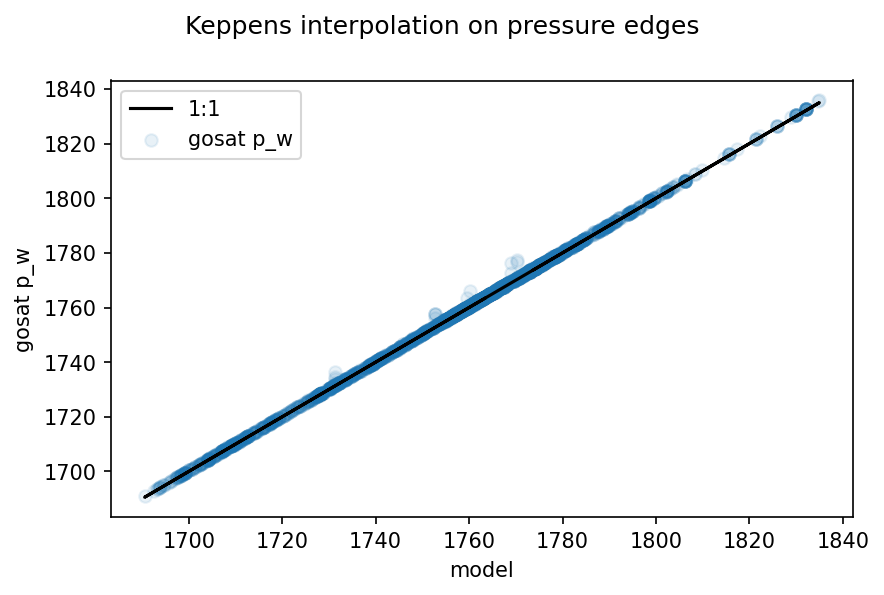

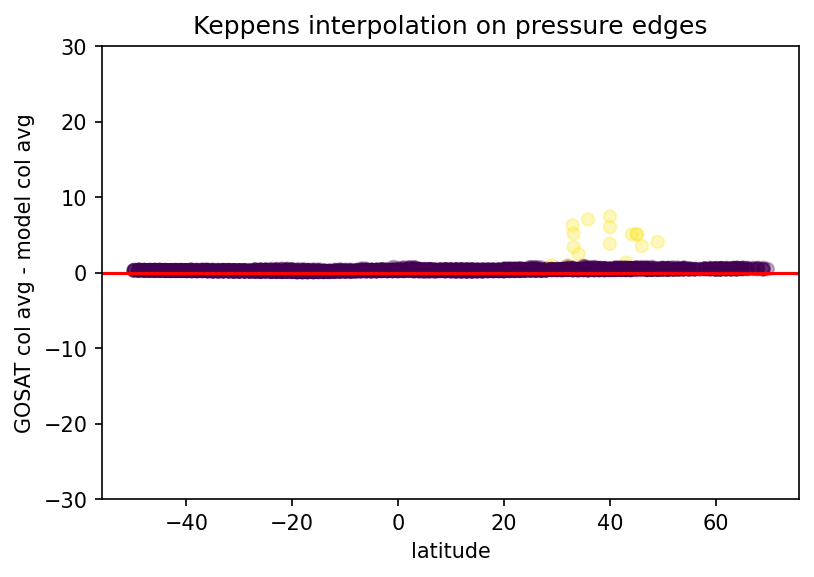

In [9]:
# Calculate model/satellite column averages to compare

# this chops off the dry air model profile where GOSAT stops
# all elements of ___ should be 1 (no change) except the first and last valid layer
overlap_map    = np.full((nobs,nsatlev-1,47),np.nan)
trimmed_model_profile   = np.full((nobs,47),np.nan)
for i in np.arange(nobs):
    overlap_map[i,:,:] = get_overlap_map(gc_pedge[i], obs_pedge[i],
                                            L0[i]+1)
    trimmed_model_profile[i,:] = overlap_map[i,:,:].sum(axis=0)*profiles['DRY_AIR'][i].data

# find where the GOSAT surface is greater than the model surface
# this is for coloring the plot
gos_surf_gt_gc = [obs_pedge[i,L0[i]] > gc_pedge[i,0] for i in np.arange(nobs)]

# calculate your model column and satellite column
model_column_trimmed = np.sum( trimmed_model_profile*gc_ch4_native,
                              axis=1 ) / trimmed_model_profile.sum(axis=1)
gos_column     = np.sum(profiles['GOSAT_PRES_W']*ch4_edges, 
                              axis=1) 
test_mass_cons(model_column_trimmed, gos_column, 
               'Keppens interpolation on pressure edges',gos_surf_gt_gc)

# 7. Double check you get the same answers as the python version

The Python code is a little messier but should do exactly the same thing (you want to see True at the end of this)

In [10]:
# unlabeled matrix in equation 11 Keppens 2019
def h_to_hprime(nsatlev):
    # could also use np.diag
    h_to_hprime = np.full((nsatlev+1,nsatlev),0.0)
    h_to_hprime[0,0]   = 1.
    h_to_hprime[-1,-1] = 1.
    for i in np.arange(nsatlev-1)+1: 
        h_to_hprime[i,i]   = 0.5 
        h_to_hprime[i,i-1] = 0.5 
    return h_to_hprime

In [11]:
# equation 11 Keppens 2019
def hprime(h,L0):
    hp = np.full(len(h)+1,-9999.)
    hp[L0:] = np.matmul(h_to_hprime(len(h)-L0), h[L0:])
    return hp

In [12]:
# Extend GEOS-Chem to the full range of GOSAT
#    if GEOS-Chem surface is higher than GOSAT, extend it down to the GOSAT surface
#    if GEOS-Chem TOA is lower than GOSAT, extend it up to the GOSAT TOA
def extend_gc(gc_pedge,gos_pedge,L0):
    nobs = gos_pedge.shape[0]
    gc_pedge_extended = np.full(gc_pedge.shape,-9999.)
    for i in np.arange(nobs):
        gc_pedge_extended[i] = np.copy(gc_pedge[i].data)
        if gos_pedge[i,L0[i]] > gc_pedge[i,0]:
            gc_pedge_extended[i,0] = gos_pedge[i,L0[i]]
        if gos_pedge[i,-1] < gc_pedge[i,-1]:
            gc_pedge_extended[i,-1] = gos_pedge[i,-1]
    return gc_pedge_extended

In [13]:
# Use the KEPPENS INTERPOLATION

# get intmap for LANGEROCK (GOSAT->GC)
nobs = len(profiles['observations'])
intmap_lr    = np.full((nobs,nsatlev,47),np.nan)
ch4_edges_lr      = np.full((nobs,nsatlev),np.nan)
trimmed_model_column_lr   = np.full((nobs,47),np.nan)
L0 = get_lowest_valid_lev(profiles['GOS_PEDGE'])
gc_pedge_extended = extend_gc(profiles['GC_PEDGE'],profiles['GOS_PEDGE'],L0)
i=0
for i in np.arange(nobs): 
    # calculate h_prime pressure levels
    gos_hprime = hprime(profiles['GOS_PEDGE'][i].data,L0[i])#hprime(profiles['GOS_PEDGE'][i].data,L0[i])
    # intmap_lr is W in eq 13
    intmap_lr[i,:,:] = get_overlap_map(gc_pedge_extended[i], gos_hprime.data,
                                            L0[i]+1)
    # M_gos and M_gc are M_out and M_in in eq 14
    M_gos = np.abs(np.diag(np.diff(gos_hprime[L0[i]:])))
    M_gc  = np.abs(np.diag(np.diff(gc_pedge_extended[i]))) # keep GC on original levels -there are no edge values for GC
    # Intermediate steps for eq 14:
    # M_in * x
    ch4_model_integrated = np.matmul(M_gc,profiles['GC_CH4_NATIVE'][i].data)
    # W * M_in * x
    ch4_interp_integrated = np.matmul(intmap_lr[i,:,:],ch4_model_integrated)
    # M_out * W * M_in * x
    ch4_edges_lr[i,L0[i]:] = np.matmul(np.linalg.inv(M_gos),ch4_interp_integrated[L0[i]:])

    trimmed_model_column_lr[i,:] = intmap_lr[i,:,:].sum(axis=0)*profiles['DRY_AIR'][i].data

In [14]:
ch4_edges_f_nan = np.copy(ch4_edges)
ch4_edges_f_nan[ch4_edges_f_nan<=0.]=np.nan
np.all(np.isclose(ch4_edges_f_nan,ch4_edges_lr,equal_nan=True))

False